# Analysis of Classification Models in Letter Recognition
### by Joshua Gabella
_______________________________________________________________________________________________________________________________


Imports

In [281]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

In [184]:
df = pd.read_csv("letter-recognition.data", index_col=False)
data = df.to_numpy()
HKdata = data[np.logical_or(data[:,0]=='H', data[:,0] == 'K'), :]
MYdata = data[np.logical_or(data[:,0]=='M', data[:,0] == 'Y'), :]
DOdata = data[np.logical_or(data[:,0]=='D', data[:,0] == 'O'), :]

## Optional Dimensionality Reduction

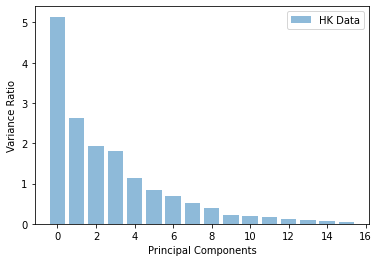

[[12 5 3 4]
 [11 2 3 3]
 [11 4 4 2]
 [1 6 5 5]
 [11 6 6 9]
 [2 6 6 7]
 [1 2 2 2]
 [2 2 4 1]
 [15 6 1 1]
 [9 3 6 6]
 [13 6 7 5]
 [9 6 5 7]
 [9 6 5 8]
 [9 7 3 5]
 [9 3 5 6]
 [4 7 6 3]
 [10 6 7 5]
 [11 5 9 2]
 [2 3 4 1]
 [3 2 5 0]
 [5 6 6 3]
 [2 7 5 9]
 [11 9 5 5]
 [6 4 8 1]
 [11 7 7 4]
 [11 4 11 5]
 [14 4 10 2]
 [9 6 7 4]
 [6 5 6 4]
 [3 5 0 0]
 [3 1 3 2]
 [12 4 11 3]
 [9 4 8 8]
 [9 3 9 2]
 [7 6 5 4]
 [7 8 6 3]
 [6 8 6 4]
 [9 4 5 5]
 [4 6 6 7]
 [11 1 5 4]
 [7 5 8 6]
 [6 2 3 4]
 [5 8 6 6]
 [9 4 10 3]
 [10 3 6 6]
 [9 5 9 3]
 [3 5 5 3]
 [10 3 4 7]
 [9 6 6 9]
 [11 6 8 8]
 [6 6 1 0]
 [4 1 11 2]
 [5 4 7 7]
 [9 7 4 9]
 [9 7 6 6]
 [5 4 4 4]
 [6 10 6 3]
 [10 6 7 5]
 [10 2 2 3]
 [3 13 6 0]
 [3 4 9 2]
 [9 4 6 7]
 [9 3 6 8]
 [3 5 6 3]
 [3 5 0 0]
 [5 3 6 3]
 [3 5 6 5]
 [10 6 8 8]
 [12 4 4 5]
 [10 5 6 9]
 [8 9 6 5]
 [6 6 7 5]
 [8 8 3 0]
 [7 1 5 1]
 [5 7 6 3]
 [6 5 5 5]
 [5 3 9 2]
 [7 3 2 3]
 [5 5 7 2]
 [10 4 11 3]
 [14 6 5 4]
 [12 4 9 8]
 [10 7 6 8]
 [3 3 8 0]
 [4 3 9 0]
 [8 4 7 4]
 [9 5 6 9]
 [7 3 10 

In [317]:
#PCAnalysis
def runPCA(data):
    training_data, test_data = train_test_split(HKdata, test_size=0.1, random_state=0)
    training_y = training_data[:, 0]
    training_X = training_data[:, 1:]
    test_y = test_data[:, 0]
    test_X = test_data[:, 1:]
    scaler = StandardScaler()
    scaler.fit(training_X)
    Xtr = scaler.transform(training_X)
    Xtest = scaler.transform(test_X)
    
    pca=PCA()
    pca.fit_transform(Xtr)
    varex = pca.explained_variance_

    plt.bar(range(len(varex)), varex, alpha = 0.5, label="HK Data") #have to hardcode data label
    plt.legend()
    plt.ylabel('Variance Ratio')
    plt.xlabel('Principal Components')
    plt.show()

def processData(data, reduce_dim=False, method='PCA'):
    features = data[:, 1:]
    labels = data[:, 0]
    if reduce_dim:
        if method=='PCA':
            scaler = StandardScaler()
            features = scaler.fit_transform(features)
            pca=PCA(n_components=4)
            features = pca.fit_transform(features)
            data = np.hstack((labels.reshape(len(features), 1), features))
        elif method=='VarianceThreshold':
            vars = []
            for col in features.T:
                vars.append(np.var(col))
            vars = np.flip(np.sort(np.array(vars)))
            selector = VarianceThreshold(threshold=(vars[3]+vars[4])/2)
            selector.fit(features)
            features = selector.transform(features)
            data = np.hstack((labels.reshape(len(features), 1), features))
    else:
        data = np.hstack((labels.reshape(len(features), 1), features))
    HKdata = data[np.logical_or(data[:,0]=='H', data[:,0] == 'K'), :]
    MYdata = data[np.logical_or(data[:,0]=='M', data[:,0] == 'Y'), :]
    DOdata = data[np.logical_or(data[:,0]=='D', data[:,0] == 'O'), :]
    return HKdata, MYdata, DOdata
    
runPCA(HKdata)
HKdata, MYdata, DOdata = processData(data, True, 'VarianceThreshold')


## H and K Analysis

In [185]:
training_data, test_data = train_test_split(HKdata, test_size=0.1, random_state=0)
training_y = training_data[:, 0]
training_X = training_data[:, 1:]
test_y = test_data[:, 0]
test_X = test_data[:, 1:]

### Kernel SVM - H/K

In [187]:
clf = GridSearchCV(svm.SVC(), {
    'C':[0.1, 1, 5, 10, 20],
    'kernel':['rbf', 'linear', 'sigmoid'],
    'gamma':['auto', 'scale']
}, cv=5)
clf.fit(training_X, training_y)
param_SVM_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_SVM_resultsHK = param_SVM_resultsHK[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score']]



In [188]:
trimmed_SVM_resultsHK.sort_values('mean_test_score', ascending=False)

---
### Decision Tree Classifier - H/K

In [189]:
clf = GridSearchCV(tree.DecisionTreeClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50]
}, cv=5)
clf.fit(training_X, training_y)
param_tree_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_tree_resultsHK = param_tree_resultsHK[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]


In [190]:
trimmed_tree_resultsHK.sort_values('mean_test_score', ascending=False)

---
### Random Forest

In [191]:
clf = GridSearchCV(RandomForestClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50],
    'n_estimators':[10, 50, 100, 200, 500]
}, cv=5)
clf.fit(training_X, training_y)
param_forest_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_forest_resultsHK = param_forest_resultsHK[['param_n_estimators', 'param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]

In [192]:
trimmed_forest_resultsHK.sort_values('mean_test_score', ascending=False)

---
### K-Nearest Neighbor - H/K

In [193]:
clf = GridSearchCV(KNeighborsClassifier(), {
    'algorithm':['ball_tree', 'brute', 'kd_tree'],
    'n_neighbors':[1, 3, 5, 10, 20],
    'weights': ['uniform', 'distance']
}, cv=5)
clf.fit(training_X, training_y)
param_knn_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_knn_resultsHK = param_knn_resultsHK[['param_n_neighbors', 'param_algorithm', 'param_weights', 'mean_test_score', 'std_test_score']]

In [210]:
trimmed_knn_resultsHK.sort_values('mean_test_score', ascending=False)

,param_n_neighbors,param_algorithm,param_weights,mean_test_score,std_test_score
25,5,kd_tree,distance,0.955472,0.007317
5,5,ball_tree,distance,0.954717,0.008268
15,5,brute,distance,0.953208,0.007395
21,1,kd_tree,distance,0.953208,0.006131
20,1,kd_tree,uniform,0.953208,0.006131
10,1,brute,uniform,0.953208,0.006579
11,1,brute,distance,0.953208,0.006579
24,5,kd_tree,uniform,0.951698,0.009057
23,3,kd_tree,distance,0.951698,0.010237
1,1,ball_tree,distance,0.951698,0.007317


---
### Artifical Neural Network - H/K

In [195]:
clf = GridSearchCV(MLPClassifier(), {
    'hidden_layer_sizes' : [(20), (10, 15, 20, 15, 10), (10, 20, 10)],
    'activation':['identity', 'relu', 'logistic']
}, cv=5)
clf.fit(training_X, training_y)
param_ann_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_ann_resultsHK = param_ann_resultsHK[['param_activation', 'param_hidden_layer_sizes','mean_test_score', 'std_test_score']]

C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

In [196]:
# trimmed_ann_resultsHK.sort_values('mean_test_score', ascending=False)

---
## M and Y Analysis

In [197]:
training_data, test_data = train_test_split(MYdata, test_size=0.1, random_state=0)
training_y = training_data[:, 0]
training_X = training_data[:, 1:]
test_y = test_data[:, 0]
test_X = test_data[:, 1:]

---
### K-Nearest Neighbor - M/Y

In [198]:
clf = GridSearchCV(KNeighborsClassifier(), {
    'algorithm':['ball_tree', 'brute', 'kd_tree'],
    'n_neighbors':[1, 3, 5, 10, 20],
    'weights': ['uniform', 'distance']
}, cv=5)
clf.fit(training_X, training_y)
param_knn_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_knn_resultsMY = param_knn_resultsMY[['param_n_neighbors', 'param_algorithm', 'param_weights', 'mean_test_score', 'std_test_score']]
# trimmed_knn_resultsMY.sort_values('mean_test_score', ascending=False)

---
### Decision Tree Classifier - M/Y

In [199]:
clf = GridSearchCV(tree.DecisionTreeClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50]
}, cv=5)
clf.fit(training_X, training_y)
param_tree_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_tree_resultsMY = param_tree_resultsMY[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
# trimmed_tree_resultsMY.sort_values('mean_test_score', ascending=False)

---
### Random Forest - M/Y

In [200]:
clf = GridSearchCV(RandomForestClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50],
    'n_estimators':[10, 50, 100, 200, 500]
}, cv=5)
clf.fit(training_X, training_y)
param_forest_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_forest_resultsMY = param_forest_resultsMY[['param_n_estimators', 'param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
# trimmed_forest_resultsMY.sort_values('mean_test_score', ascending=False)

---
### Kernel SVM - M/Y

In [201]:
clf = GridSearchCV(svm.SVC(), {
    'C':[0.1, 1, 5, 10, 20],
    'kernel':['rbf', 'linear', 'sigmoid'],
    'gamma':['auto', 'scale']
}, cv=5)
clf.fit(training_X, training_y)
param_SVM_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_SVM_resultsMY = param_SVM_resultsMY[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score']]
# trimmed_SVM_resultsMY.sort_values('mean_test_score', ascending=False)

---
### Artifical Neural Network - M/Y

In [202]:
clf = GridSearchCV(MLPClassifier(), {
    'hidden_layer_sizes' : [(20), (10, 15, 20, 15, 10), (10, 20, 10)],
    'activation':['identity', 'relu', 'logistic']
}, cv=5)
clf.fit(training_X, training_y)
param_ann_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_ann_resultsMY = param_ann_resultsMY[['param_activation', 'param_hidden_layer_sizes','mean_test_score', 'std_test_score']]
# trimmed_ann_resultsMY.sort_values('mean_test_score', ascending=False)

C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

---
## D/O Analysis

In [203]:
training_data, test_data = train_test_split(DOdata, test_size=0.1, random_state=0)
training_y = training_data[:, 0]
training_X = training_data[:, 1:]
test_y = test_data[:, 0]
test_X = test_data[:, 1:]

---
### K-Nearest Neighbor - D/O

In [204]:
clf = GridSearchCV(KNeighborsClassifier(), {
    'algorithm':['ball_tree', 'brute', 'kd_tree'],
    'n_neighbors':[1, 3, 5, 10, 20],
    'weights': ['uniform', 'distance']
}, cv=5)
clf.fit(training_X, training_y)
param_knn_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_knn_resultsDO = param_knn_resultsDO[['param_n_neighbors', 'param_algorithm', 'param_weights', 'mean_test_score', 'std_test_score']]
# trimmed_knn_resultsDO.sort_values('mean_test_score', ascending=False)

---
### Decision Tree Classifier - D/O

In [205]:
clf = GridSearchCV(tree.DecisionTreeClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50]
}, cv=5)
clf.fit(training_X, training_y)
param_tree_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_tree_resultsDO = param_tree_resultsDO[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
# trimmed_tree_resultsDO.sort_values('mean_test_score', ascending=False)

---
### Random Forest - D/O

In [206]:
clf = GridSearchCV(RandomForestClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50],
    'n_estimators':[10, 50, 100, 200, 500]
}, cv=5)
clf.fit(training_X, training_y)
param_forest_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_forest_resultsDO = param_forest_resultsDO[['param_n_estimators', 'param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
# trimmed_forest_resultsDO.sort_values('mean_test_score', ascending=False)

---
### Kernel SVM - D/O

In [207]:
clf = GridSearchCV(svm.SVC(), {
    'C':[0.1, 1, 5, 10, 20],
    'kernel':['rbf', 'linear', 'sigmoid'],
    'gamma':['auto', 'scale']
}, cv=5)
clf.fit(training_X, training_y)
param_SVM_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_SVM_resultsDO = param_SVM_resultsDO[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score']]
trimmed_SVM_resultsDO.sort_values('mean_test_score', ascending=False)

,param_C,param_kernel,param_gamma,mean_test_score,std_test_score
18,10,rbf,auto,0.992867,0.005036
24,20,rbf,auto,0.992867,0.005036
12,5,rbf,auto,0.992867,0.005036
21,10,rbf,scale,0.992150,0.004733
15,5,rbf,scale,0.992148,0.007285
6,1,rbf,auto,0.991436,0.006224
27,20,rbf,scale,0.990722,0.005801
9,1,rbf,scale,0.990015,0.006921
4,0.1,linear,scale,0.967191,0.013008
1,0.1,linear,auto,0.967191,0.013008


---
### Artifical Neural Network - D/O

In [208]:
clf = GridSearchCV(MLPClassifier(), {
    'hidden_layer_sizes' : [(20), (10, 15, 20, 15, 10), (10, 20, 10)],
    'activation':['identity', 'relu', 'logistic']
}, cv=5)
clf.fit(training_X, training_y)
param_ann_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_ann_resultsDO = param_ann_resultsDO[['param_activation', 'param_hidden_layer_sizes','mean_test_score', 'std_test_score']]
# trimmed_ann_resultsDO.sort_values('mean_test_score', ascending=False)

C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

---
## Graphing

Text(0.5, 0.98, 'SVM Results, No Reduction')

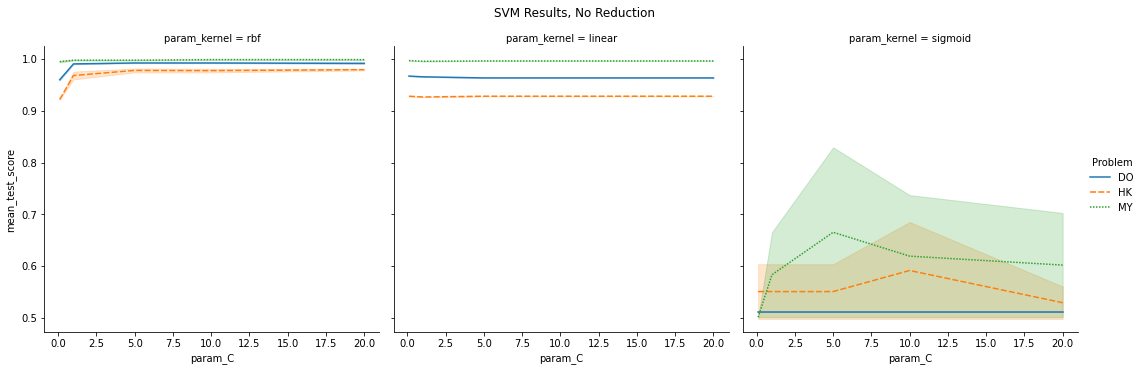

In [235]:
trimmed_SVM_resultsDO
svm_do = trimmed_SVM_resultsDO.assign(Problem='DO')
svm_hk = trimmed_SVM_resultsHK.assign(Problem='HK')
svm_my = trimmed_SVM_resultsMY.assign(Problem='MY')
svm_results = pd.concat([svm_do, svm_hk, svm_my])
svm_results
rp = sns.relplot(
    x="param_C", 
    y="mean_test_score", 
    data=svm_results, 
    col="param_kernel", 
    hue="Problem", 
    style="Problem", 
    kind="line")
rp.fig.subplots_adjust(top=0.87)
rp.fig.suptitle('SVM Results, No Reduction')

Text(0.5, 0.98, 'KNN Results, No Reduction')

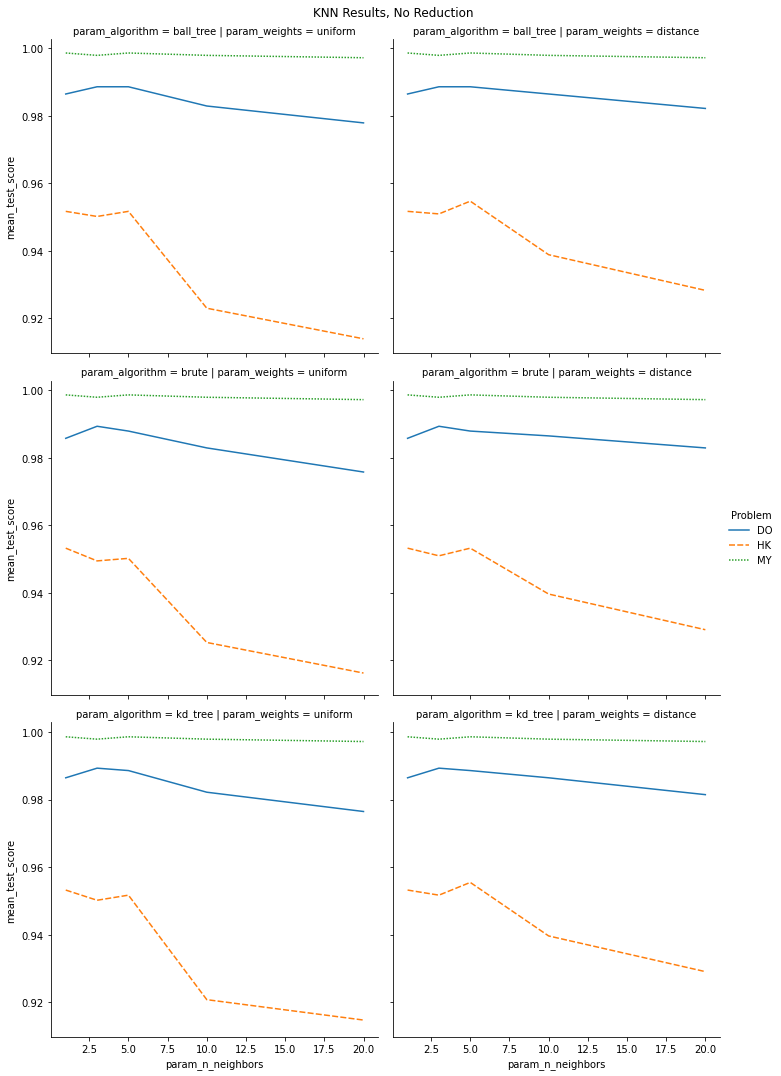

In [227]:
knn_do = trimmed_knn_resultsDO.assign(Problem='DO')
knn_hk = trimmed_knn_resultsHK.assign(Problem='HK')
knn_my = trimmed_knn_resultsMY.assign(Problem='MY')
knn_results = pd.concat([knn_do, knn_hk, knn_my])
knn_results
rp = sns.relplot(
    x="param_n_neighbors", 
    y="mean_test_score", 
    data=knn_results, 
    col="param_weights", 
    row="param_algorithm", 
    hue="Problem", style="Problem", kind="scatter")
rp.fig.subplots_adjust(top=0.95)
rp.fig.suptitle('KNN Results, No Reduction')

Text(0.5, 0.98, 'DecisionTree Results, No Reduction')

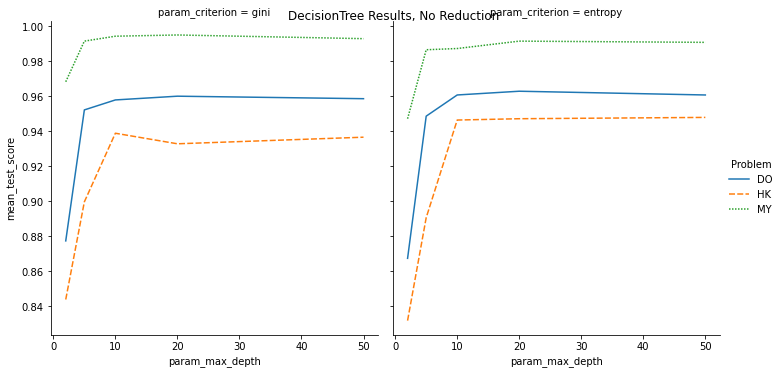

In [241]:
tree_do = trimmed_tree_resultsDO.assign(Problem='DO')
tree_hk = trimmed_tree_resultsHK.assign(Problem='HK')
tree_my = trimmed_tree_resultsMY.assign(Problem='MY')
tree_results = pd.concat([tree_do, tree_hk, tree_my])
rp = sns.relplot(
    x="param_max_depth", 
    y="mean_test_score", 
    data=tree_results, 
    col="param_criterion", 
    hue="Problem", style="Problem", kind="line")
rp.fig.subplots_adjust(top=0.95)
rp.fig.suptitle('DecisionTree Results, No Reduction')

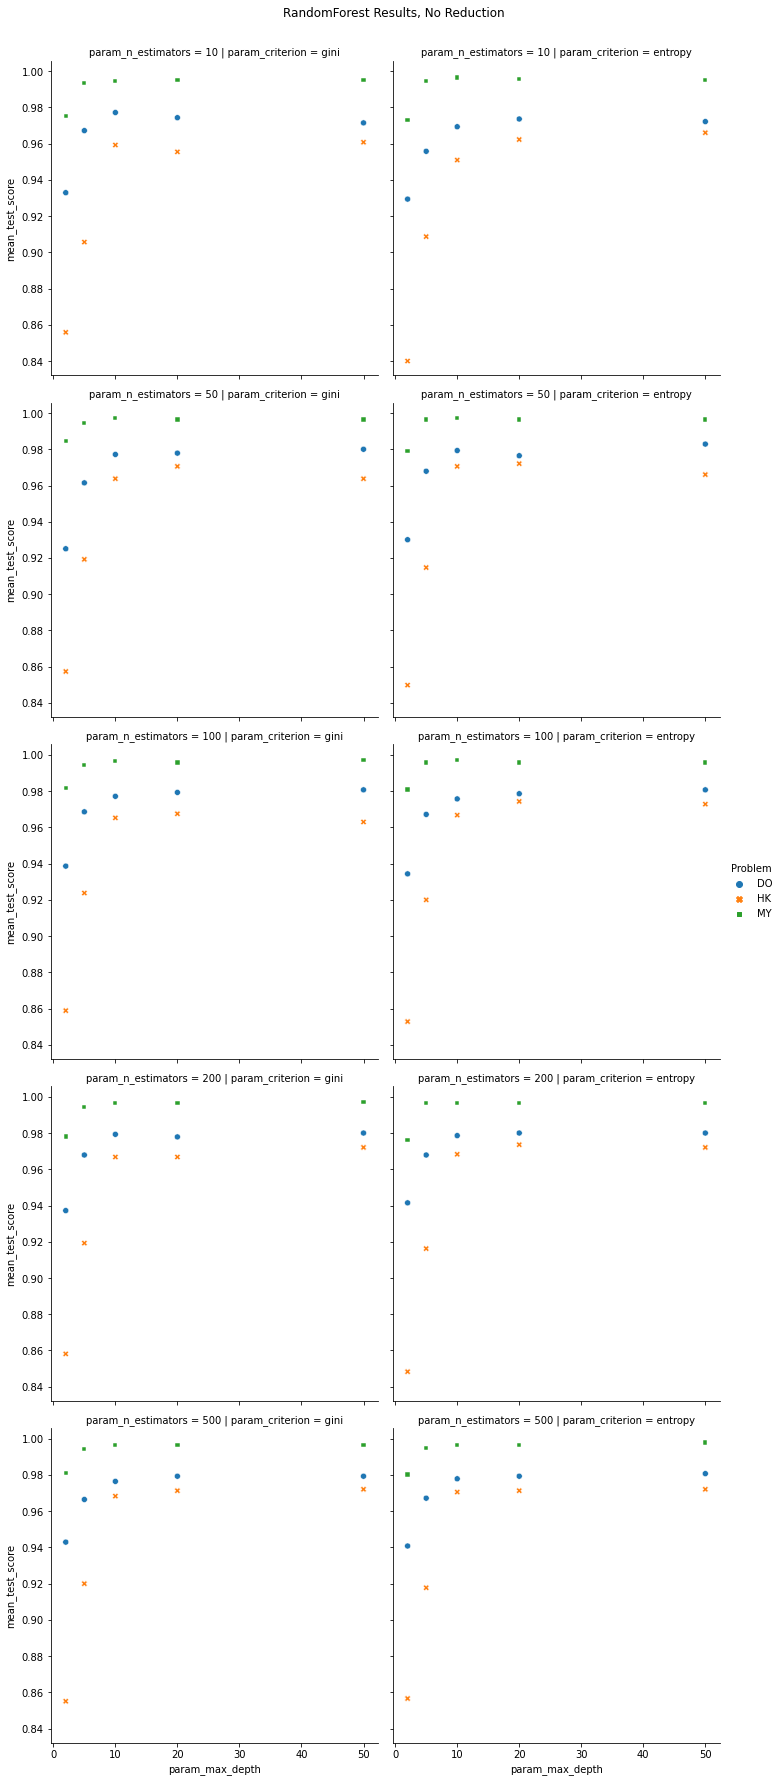

In [242]:
forest_do = trimmed_forest_resultsDO.assign(Problem='DO')
forest_hk = trimmed_forest_resultsHK.assign(Problem='HK')
forest_my = trimmed_forest_resultsMY.assign(Problem='MY')
forest_results = pd.concat([forest_do, forest_hk, forest_my])
forest_results
rp = sns.relplot(
    x="param_max_depth", 
    y="mean_test_score", 
    data=forest_results, 
    col="param_criterion", 
    row="param_n_estimators", 
    hue="Problem", style="Problem", kind="scatter")
rp.fig.suptitle('RandomForest Results, No Reduction')
rp.fig.subplots_adjust(top=0.95)

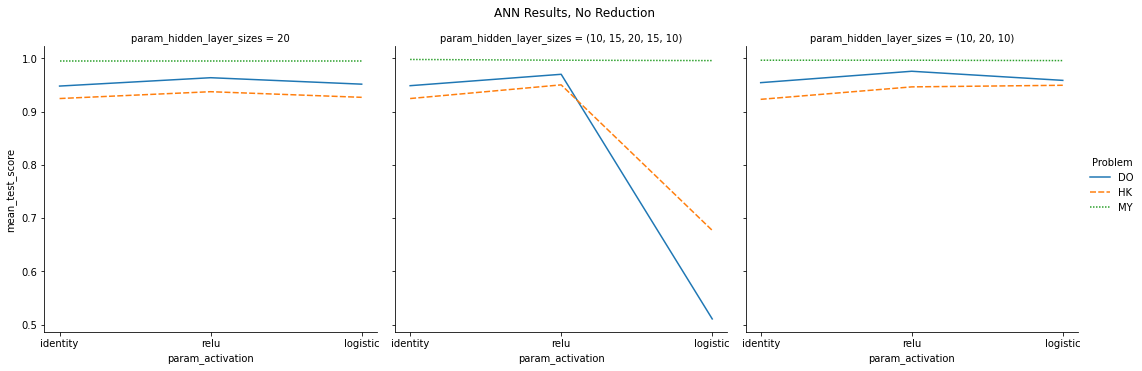

In [250]:
ann_do = trimmed_ann_resultsDO.assign(Problem='DO')
ann_hk = trimmed_ann_resultsHK.assign(Problem='HK')
ann_my = trimmed_ann_resultsMY.assign(Problem='MY')
ann_results = pd.concat([ann_do, ann_hk, ann_my])
ann_results
rp = sns.relplot(
    x="param_activation", 
    y="mean_test_score", 
    data=ann_results, 
    col="param_hidden_layer_sizes", 
    hue="Problem", style="Problem", kind="line")
rp.fig.suptitle('ANN Results, No Reduction')
rp.fig.subplots_adjust(top=0.87)